In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sbi.inference import SNLE
from sbi.utils.get_nn_models import likelihood_nn
from sbi import utils
import pickle


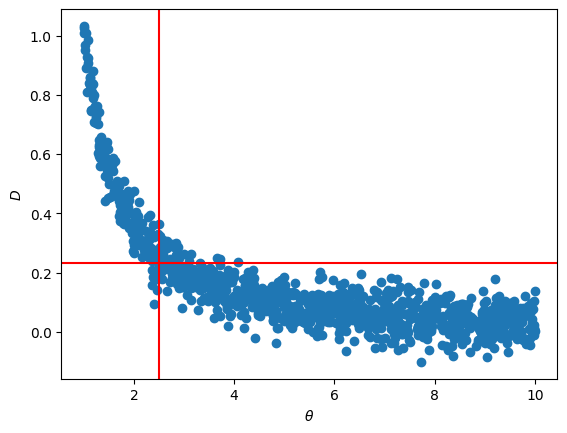

In [27]:
np.random.seed(0)
torch.manual_seed(0)

def simulation(theta):
    return theta**(-1.5) + torch.normal(0, 0.05, size=theta.shape)

torch_prior = utils.BoxUniform(low=torch.tensor([1]),
                            high=torch.tensor([10]))

prior_sample = torch_prior.sample((1000,))
data = simulation(prior_sample)
true_data = simulation(torch.tensor([2.5]))

np.savetxt('true_data.txt', true_data)

plt.scatter(prior_sample, data)
plt.axvline(2.5, color='r')
plt.axhline(true_data, color='r')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$D$')
plt.savefig('data.png', dpi=300, bbox_inches='tight')

In [24]:
from scipy.stats import norm, uniform

def likelihood(theta):
    return norm.logpdf(theta**(-1.5), loc=true_data.numpy(), scale=0.05)

# unifrom between loc and loc+scale
stats_prior = uniform.logpdf(2.5, loc=1, scale=9).sum()

from scipy.integrate import quad

integration = quad(lambda theta: np.exp(likelihood(theta) + 
                   uniform.logpdf(theta, loc=1, scale=9)), 1, 10)
print(integration)
print(np.log(integration[0]))
np.savetxt('raw-integration-evidence.txt', [np.log(integration[0])])


(0.9607335873458359, 7.019434931267731e-09)
-0.04005813285163156


In [25]:
density_estimator_build_fun = likelihood_nn(
    model="maf", hidden_features=50,  
    num_transforms=2, z_score_x=None, z_score_theta=None,
    use_batch_norm=True,
)

inference = SNLE(prior=torch_prior, density_estimator=density_estimator_build_fun)
inference = inference.append_simulations(prior_sample, data)
density_estimator = inference.train()
with open('density_estimator.pkl', 'wb') as f:
    pickle.dump(density_estimator, f)



/opt/homebrew/lib/python3.11/site-packages/sbi/neural_nets/flow.py:142: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 101 epochs.